# Neural Network from scratch

We will building and train a neural network using only numpy.** Scikit-learn has been imported only to create a toy dataset.** We will use our neural network to classify this toy dataset and also lastly visualize the decision boundary that it has been trained to.

First we generate a dataset and shown below using scitkit-learn. We are also converting the labels in one-hot-vector format. So for 2 classes, there will be 2 output neurons and either one will fire indicating one of the class.


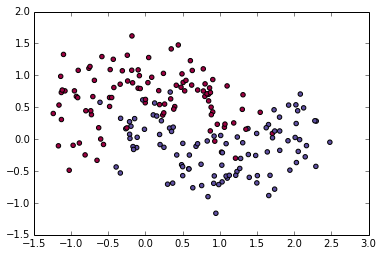

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn.datasets

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline

n_samples = 200
x,Y = sklearn.datasets.make_moons(n_samples=n_samples, noise=0.3, random_state=1)
#x,Y = sklearn.datasets.make_circles(n_samples=n_samples, noise=0.3, random_state=1, factor=0.2)

plt.scatter(x[:,0], x[:,1], c=Y, cmap=plt.cm.Spectral)
plt.show()

#creating one hot vector for target label y
y = np.eye(3)[Y]
y = y[:,0:2]

## Activation and Loss functions

The network uses sigmoid as the activation function and cross entropy as the cost/loss function. We will use backpropagation algorithm to minimize this cross entropy loss.

Sigmoid Activation is given as, $$ S(z) = \frac{1} {1 + e^{-z}} $$

And its derivative(we will need this in backpropagation) is given as, $$ S'(z) = S(z) \cdot (1 - S(z)) $$

Cross Entropy Loss function is given as, $$ J(W) = -\frac{1} {M} \sum_{i=1}^K\sum_{j=1}^M {(y\log(a) + (1 - y)\log(1 - a))}$$

Here, 'a' is the activation given by the output layer. In this case it will be 2x1 martix for 2 output neurons. <br/>
'y' is the one hot vector and it is also 2x1 matrix.
<br/>
'M' is the total number of datapoints we have, in our case it is 200.
<br/>
'K' is the total number of output neurons, in our case it is 2.

There is a beautiful article on cross entropy and very well explained in detail as to how and why we use it [here](http://neuralnetworksanddeeplearning.com/chap3.html).

## Initializing our neural network

Lets say for our case we will design a network with only 1 hidden layer having 3 neurons in that layer. We will first randomly initialize the weights of our network and then keep updating them so as to learn the given dataset.

![](3 layer network.png)

## Forward Propagation 

We will use forward propagation for computing the output of our neural network form a given input vector i.e. this is how our network will make predictions. Then we will calculate the errors in the prediction for training. The steps of forward propagation is given below,

$$\begin{align*}
z_2 = W_1 x + b_1 \newline 
a_2 = sigmoid(z_2) \newline 
z_3 = W_2 a_2 + b_2 \newline 
a_3 = sigmoid(z_3)
\end{align*}$$



## Backpropagation 

Here we will actually see how to calculate the errors and update the weights. After performing forward propagation, we then do the following steps. We first calculate the error terms, lets call them delta terms.

$$ \delta^{(3)} = a^{(3)} - y $$

$$ \delta^{(2)} = (W_2)^T \delta^{(3)} * S'(z_2) $$

Above equations are only showed for our network for 3 layers however we can keep porpagating the error back using equation similar to second one for network having more layers.

Now after calculating the deltas, we calculate the gradients. We first initialize the matix to all zeros to hold the gradients of weight matrix. We calculate this by adding all the values for the whole training set.

$$ \Delta^{(l)} = \sum_{j=1}^M \delta^{(l+1)}(a^{(l)})^T $$

This is for $l^{th}$ weight matrix we are calculating. Then the final gradient matrix is given by dividing by the number of datapoints in the dataset.

$$ D^{(l)} = \frac{1}{M}\Delta^{(l)} $$

Then finally we update the weight martix by a factor of this gradients. $\beta$ is called the learning rate that determines to what extent should we update the weights.

$$ W^{(l)} = W^{(l)} -  \beta * D^{(l)} $$

However the bias is updated is a slightly different way as shown below.

$$ b^{(l)} = b^{(l)} -  \beta *\frac{1}{M} \sum_{j=1}^M  \delta^{(l+1)} $$

In [2]:
def sigmoid(r):
    return 1/(np.exp(-r) + 1)

#function returns the cross entropy cost
def cal_cost(model):
    _, b = predict(model, x.T)
    cost = (-1 / n_samples) * np.sum(np.multiply(y,np.log(b)) + np.multiply((1-y),np.log(1-b)))
    return cost

#used to initialize the weights of the neural network
def nn_model_init(h_hidden):
    n_input = 2
    n_ouput = 2
    h_hidden = h_hidden
    
    np.random.seed(0)
    w1 = np.random.randn(h_hidden, n_input +1)
    w2 = np.random.randn(n_ouput, h_hidden +1)
    
    model = { 'w1': w1, 'w2': w2, 'h_hidden': h_hidden}
    return model


# i is the input(to feed into nn) of shape (2, 1) and function returns an output of shape (2, 1)
def predict(model, i):
    w1, w2, h_hidden = model['w1'], model['w2'], model['h_hidden']
    #i = np.asarray([i]).T
    #seperating bias terms from weight matrix
    b1 = np.asarray([w1[:,0]]).T
    b2 = np.asarray([w2[:,0]]).T

    z2 = np.matmul(w1[:,1:h_hidden], i)
    z2 = z2 + b1
    a2 = sigmoid(z2)

    z3 = np.matmul(w2[:,1:h_hidden+1], a2)
    z3 = z3 + b2
    a3 = sigmoid(z3)
    
    return np.argmax(a3, axis=0), a3.T


# training neural network using backpropagation
def train(model, x, y, epochs=1000, learning_rate=0.1):
    w1, w2, h_hidden = model['w1'], model['w2'], model['h_hidden']
    
    for e in range(epochs):
        dw1 = np.zeros((w1.shape[0], w1.shape[1] -1))
        dw2 = np.zeros((w2.shape[0], w2.shape[1] -1))
        db1 = np.zeros((w1.shape[0], 1))
        db2 = np.zeros((w2.shape[0], 1))
        
        #seperating bias terms from weight matrix
        b1 = np.asarray([w1[:,0]]).T
        b2 = np.asarray([w2[:,0]]).T
        
        for i in range(n_samples):
            #first we perfom the forward propagation
            a1 = np.asarray([x[i]]).T
            
            z2 = np.matmul(w1[:,1:h_hidden], a1)
            z2 = z2 + b1
            a2 = sigmoid(z2)

            z3 = np.matmul(w2[:,1:h_hidden+1], a2)
            z3 = z3 + b2
            a3 = sigmoid(z3)

            #calculating error terms for backpropagation
            delta3 = a3 - np.asarray([y[i]]).T
            delta2 = np.matmul(w2[:,1:h_hidden+1].T, delta3) * (a2*(1-a2))
           
            #calculating the gradients and adding them all
            dw1 += np.matmul(delta2, a1.T)
            dw2 += np.matmul(delta3, a2.T)
            db1 += delta2
            db2 += delta3
        
        dw1 = dw1/n_samples
        dw2 = dw2/n_samples
        db1 = db1/n_samples
        db2 = db2/n_samples
        
        #combining bias and weights in one matrix
        dw1 = np.hstack((db1, dw1))
        dw2 = np.hstack((db2, dw2))
        
        #updatin the weights
        w1 = w1 - (learning_rate * dw1)
        w2 = w2 - (learning_rate * dw2)
        model = { 'w1': w1, 'w2': w2, 'h_hidden': h_hidden}
        if e%100 == 0:
            print("Loss after epoch %i: %f" %(e, cal_cost(model)))
        
    model = { 'w1': w1, 'w2': w2, 'h_hidden': h_hidden}
    print("model trained")
    return model

In [3]:
model = nn_model_init(3)

model = train(model, x, y, epochs=2000, learning_rate=0.6)

Loss after epoch 0: 1.877887
Loss after epoch 100: 0.814105
Loss after epoch 200: 0.708122
Loss after epoch 300: 0.694220
Loss after epoch 400: 0.682069
Loss after epoch 500: 0.668086
Loss after epoch 600: 0.654089
Loss after epoch 700: 0.641559
Loss after epoch 800: 0.630664
Loss after epoch 900: 0.620572
Loss after epoch 1000: 0.606663
Loss after epoch 1100: 0.565744
Loss after epoch 1200: 0.516490
Loss after epoch 1300: 0.476751
Loss after epoch 1400: 0.448713
Loss after epoch 1500: 0.429639
Loss after epoch 1600: 0.416568
Loss after epoch 1700: 0.407417
Loss after epoch 1800: 0.400839
Loss after epoch 1900: 0.395976
model trained


As seen above, we keep printing the cross entropy loss for every 100th epoch. We can see that we goes on decreasing. Next we plot the decision boundary to see how well our model has been trained.

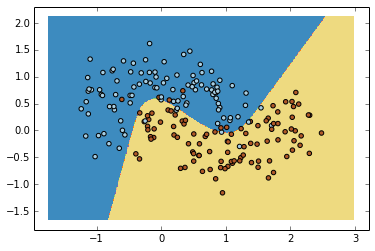

In [4]:
#Plotting the decision boundary
h = 0.01
# create a mesh to plot in
x_min, x_max = x[:, 0].min() - 0.5, x[:, 0].max() + 0.5
y_min, y_max = x[:, 1].min() - 0.5, x[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

Z, _ = predict(model, np.c_[xx.ravel(), yy.ravel()].T)
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
plt.scatter(x[:, 0], x[:, 1], c=Y, cmap=plt.cm.Paired)
plt.show()

# Conclusion

Neural Network can be very useful in fitting complex non-linear dataset. The hidden layer first converts the inputs to some intermidiate features required for predicting the class.

How exactly to convert the input into those features is automatically learned by the network while perfoming backpropagation. This is the main advantage of neural networks over any other machine learning algorithm. Thats the reason we call it end-to-end machine learning model as it dosent require us to first convert the input into some features and then feed it in. 